<a href="https://colab.research.google.com/github/lungnahahd/Tensorflow_Prac/blob/main/colorectal_histology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
from tensorflow import keras
from functools import partial
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load("colorectal_histology",split=["train[:2%]", "train[20%:22%]","train[40%:46%]"])

# Data Augmentation (가운데 자르기 변형)
def central_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]])
  top_crop = (shape[0] - min_dim) // 4
  bottom_crop = shape[0] - top_crop
  left_crop = (shape[1] - min_dim) // 4
  right_crop = shape[1] - left_crop
  return image[top_crop:bottom_crop, left_crop:right_crop]

# Data Augmetation (일부를 랜덤하게 자르기 변형)
def random_crop(image):
  shape = tf.shape(image)
  min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
  return tf.image.random_crop(image,[min_dim,min_dim,3])

#### Central_Crop 처리 과정

In [46]:
# 데이터를 MNIST 변형 계층에 넣기 위해 dataset prcessing 하는 부분
x_train_set, y_train_set = np.empty((0,150,150,3), np.uint8), np.empty((0,),np.uint8)
for i in train_set_raw:
  temp = central_crop(i['image'].numpy())
  x_train_set = np.append(x_train_set,np.expand_dims(temp, axis=0), axis=0)
  y_train_set = np.append(y_train_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_test_set, y_test_set = np.empty((0,150,150,3), np.uint8), np.empty((0,),np.uint8)
for i in test_set_raw:
  temp = central_crop(i['image'].numpy())
  x_test_set = np.append(x_test_set,np.expand_dims(temp, axis=0), axis=0)
  y_test_set = np.append(y_test_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_valid_set, y_valid_set = np.empty((0,150,150,3), np.uint8), np.empty((0,),np.uint8)
for i in valid_set_raw:
  temp = central_crop(i['image'].numpy())
  x_valid_set = np.append(x_valid_set,np.expand_dims(temp, axis=0), axis=0)
  y_valid_set = np.append(y_valid_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

#### Random_Crop 처리 과정

In [60]:
# 데이터를 MNIST 변형 계층에 넣기 위해 dataset prcessing 하는 부분
x_train_set, y_train_set = np.empty((0,135,135,3), np.uint8), np.empty((0,),np.uint8)
for i in train_set_raw:
  temp = random_crop(i['image'].numpy())
  temp = tf.image.random_flip_left_right(temp)
  x_train_set = np.append(x_train_set,np.expand_dims(temp.numpy(), axis=0), axis=0)
  y_train_set = np.append(y_train_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_test_set, y_test_set = np.empty((0,135,135,3), np.uint8), np.empty((0,),np.uint8)
for i in test_set_raw:
  temp = random_crop(i['image'].numpy())
  x_test_set = np.append(x_test_set,np.expand_dims(temp, axis=0), axis=0)
  y_test_set = np.append(y_test_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_valid_set, y_valid_set = np.empty((0,135,135,3), np.uint8), np.empty((0,),np.uint8)
for i in valid_set_raw:
  temp = random_crop(i['image'].numpy())
  x_valid_set = np.append(x_valid_set,np.expand_dims(temp, axis=0), axis=0)
  y_valid_set = np.append(y_valid_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

#### MNIST CNN 변형 모델

In [ ]:

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[135, 135, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=8, activation='softmax'),
])

#### Central Augmentation fit 진행

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, epochs=10, validation_data=(x_valid_set, y_valid_set), callbacks=early_stopping)

Epoch 1/10
10/10 [==============================] - 103s 10s/step - loss: 2.7225 - accuracy: 0.1467 - val_loss: 2.0647 - val_accuracy: 0.2500
Epoch 2/10
10/10 [==============================] - 95s 10s/step - loss: 2.1014 - accuracy: 0.1067 - val_loss: 11.3286 - val_accuracy: 0.1500
Epoch 3/10
10/10 [==============================] - 94s 9s/step - loss: 4.8605 - accuracy: 0.1100 - val_loss: 2.0441 - val_accuracy: 0.2300
Epoch 4/10
10/10 [==============================] - 95s 10s/step - loss: 2.5425 - accuracy: 0.1567 - val_loss: 2.0931 - val_accuracy: 0.1400
Epoch 5/10
10/10 [==============================] - 94s 9s/step - loss: 2.6850 - accuracy: 0.1333 - val_loss: 2.0892 - val_accuracy: 0.1700
Epoch 6/10
10/10 [==============================] - 94s 9s/step - loss: 2.1917 - accuracy: 0.1367 - val_loss: 2.0308 - val_accuracy: 0.2800
Epoch 7/10
10/10 [==============================] - 97s 10s/step - loss: 2.0376 - accuracy: 0.1833 - val_loss: 1.9303 - val_accuracy: 0.1600
Epoch 8/10
10/

#### Central Augmentation 진행 결과

In [ ]:
model.evaluate(x_test_set,y_test_set)

4/4 [==============================] - 20s 4s/step - loss: 2.0834 - accuracy: 0.0900


[2.083388566970825, 0.09000000357627869]

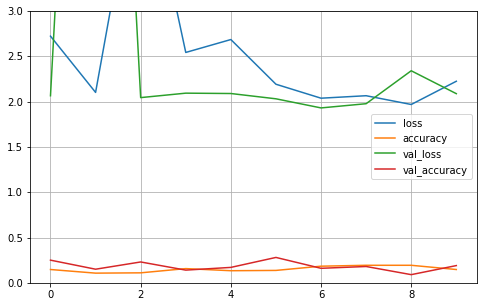

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
#save_fig("keras_learning_curves_plot")
plt.show()

#### Random Augmentation fit 진행

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, epochs=10, validation_data=(x_valid_set, y_valid_set), callbacks=early_stopping)

Epoch 1/10
10/10 [==============================] - 79s 8s/step - loss: 29.0040 - accuracy: 0.1167 - val_loss: 2.0797 - val_accuracy: 0.1200
Epoch 2/10
10/10 [==============================] - 78s 8s/step - loss: 2.1811 - accuracy: 0.1000 - val_loss: 2.2243 - val_accuracy: 0.1200
Epoch 3/10
10/10 [==============================] - 76s 8s/step - loss: 2.1911 - accuracy: 0.1267 - val_loss: 2.0177 - val_accuracy: 0.2400
Epoch 4/10
10/10 [==============================] - 76s 8s/step - loss: 1.9964 - accuracy: 0.2133 - val_loss: 1.9204 - val_accuracy: 0.1800
Epoch 5/10
10/10 [==============================] - 76s 8s/step - loss: 1.9982 - accuracy: 0.1767 - val_loss: 2.0708 - val_accuracy: 0.0900
Epoch 6/10
10/10 [==============================] - 77s 8s/step - loss: 1.9958 - accuracy: 0.2000 - val_loss: 1.8227 - val_accuracy: 0.2000
Epoch 7/10
10/10 [==============================] - 76s 8s/step - loss: 1.9430 - accuracy: 0.2267 - val_loss: 1.9524 - val_accuracy: 0.2500
Epoch 8/10
10/10 [=

#### Random Augmentation 결과

In [ ]:
model.evaluate(x_test_set,y_test_set)

4/4 [==============================] - 11s 2s/step - loss: 1.9768 - accuracy: 0.1400


[1.9768184423446655, 0.14000000059604645]

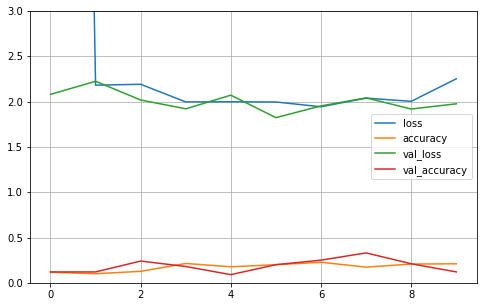

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,3)
#save_fig("keras_learning_curves_plot")
plt.show()

#### 14.11 9번 변형

### 데이터를 MNIST 변형 계층에 넣기 위해 dataset prcessing 하는 부분

In [21]:
x_train_set = x_train_set / 255.
y_train_set = y_train_set / 255.
x_valid_set = x_valid_set / 255.
y_valid_set = y_valid_set / 255.
x_test_set = x_test_set / 255.
y_test_set = y_test_set / 255.

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(8, activation="softmax")
])

#### Central Augmentation fit 진행

In [7]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, epochs=10, validation_data=(x_valid_set, y_valid_set), callbacks=early_stopping)

Epoch 1/10
10/10 [==============================] - 37s 3s/step - loss: 0.1989 - accuracy: 0.1133 - val_loss: 0.0000e+00 - val_accuracy: 0.1600
Epoch 2/10
10/10 [==============================] - 33s 3s/step - loss: 0.0000e+00 - accuracy: 0.1233 - val_loss: 0.0000e+00 - val_accuracy: 0.1600
Epoch 3/10
10/10 [==============================] - 34s 3s/step - loss: 0.0000e+00 - accuracy: 0.1233 - val_loss: 0.0000e+00 - val_accuracy: 0.1600
Epoch 4/10
10/10 [==============================] - 32s 3s/step - loss: 0.0000e+00 - accuracy: 0.1233 - val_loss: 0.0000e+00 - val_accuracy: 0.1600
Epoch 5/10
10/10 [==============================] - 32s 3s/step - loss: 0.0000e+00 - accuracy: 0.1233 - val_loss: 0.0000e+00 - val_accuracy: 0.1600
Epoch 6/10
10/10 [==============================] - 29s 3s/step - loss: 0.0000e+00 - accuracy: 0.1233 - val_loss: 0.0000e+00 - val_accuracy: 0.1600


#### Central Augmentation fit 학습 결과

In [8]:
model.evaluate(x_test_set,y_test_set)

4/4 [==============================] - 2s 469ms/step - loss: 0.0000e+00 - accuracy: 0.1000


[0.0, 0.10000000149011612]

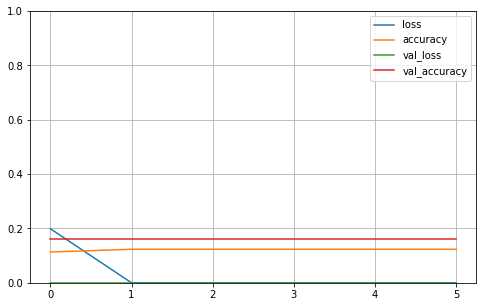

In [10]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

#### Random Augmentation fit

In [23]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, epochs=10, validation_data=(x_valid_set, y_valid_set), callbacks=early_stopping)

Epoch 1/10
10/10 [==============================] - 28s 3s/step - loss: 0.2017 - accuracy: 0.1167 - val_loss: 0.0000e+00 - val_accuracy: 0.1600
Epoch 2/10
10/10 [==============================] - 27s 3s/step - loss: 0.0000e+00 - accuracy: 0.1233 - val_loss: 0.0000e+00 - val_accuracy: 0.1600
Epoch 3/10
10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00 - accuracy: 0.1233 - val_loss: 0.0000e+00 - val_accuracy: 0.1600
Epoch 4/10
10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00 - accuracy: 0.1233 - val_loss: 0.0000e+00 - val_accuracy: 0.1600
Epoch 5/10
10/10 [==============================] - 27s 3s/step - loss: 0.0000e+00 - accuracy: 0.1233 - val_loss: 0.0000e+00 - val_accuracy: 0.1600
Epoch 6/10
10/10 [==============================] - 26s 3s/step - loss: 0.0000e+00 - accuracy: 0.1233 - val_loss: 0.0000e+00 - val_accuracy: 0.1600


#### Random Augmentation fit 학습 결과

In [15]:
model.evaluate(x_test_set,y_test_set)

4/4 [==============================] - 2s 402ms/step - loss: 0.0000e+00 - accuracy: 0.1000


[0.0, 0.10000000149011612]

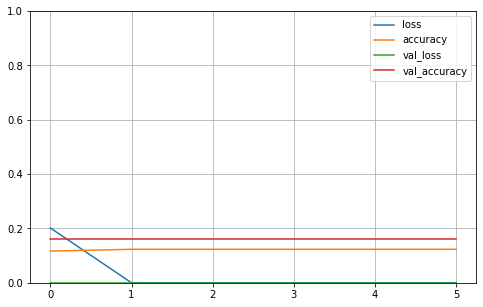

In [17]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

### Xception 사용

#### 데이터 전처리

In [26]:
x_train_set, y_train_set = np.empty((0,224,224,3), np.uint8), np.empty((0,),np.uint8)
for i in train_set_raw:
  temp = central_crop(i['image'].numpy())
  temp = tf.image.resize(temp, [224,224])
  temp = keras.applications.xception.preprocess_input(temp)
  x_train_set = np.append(x_train_set,np.expand_dims(temp, axis=0), axis=0)
  y_train_set = np.append(y_train_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_test_set, y_test_set = np.empty((0,224,224,3), np.uint8), np.empty((0,),np.uint8)
for i in test_set_raw:
  temp = central_crop(i['image'].numpy())
  temp = tf.image.resize(temp, [224,224])
  temp = keras.applications.xception.preprocess_input(temp)
  x_test_set = np.append(x_test_set,np.expand_dims(temp, axis=0), axis=0)
  y_test_set = np.append(y_test_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_valid_set, y_valid_set = np.empty((0,224,224,3), np.uint8), np.empty((0,),np.uint8)
for i in valid_set_raw:
  temp = central_crop(i['image'].numpy())
  temp = tf.image.resize(temp, [224,224])
  temp = keras.applications.xception.preprocess_input(temp)
  x_valid_set = np.append(x_valid_set,np.expand_dims(temp, axis=0), axis=0)
  y_valid_set = np.append(y_valid_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

In [30]:
base_model = keras.applications.xception.Xception(weights=None,include_top=False) # 여기를 NONE으로 해야되는지는 고민해보기
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(8, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

#### Central Augmentation fit

In [31]:
for layer in base_model.layers:
    layer.trainable = False


optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train_set,y_train_set, validation_data=(x_valid_set, y_valid_set),epochs=5)

Epoch 1/5
10/10 [==============================] - 75s 7s/step - loss: 2.0833 - accuracy: 0.0833 - val_loss: 2.0830 - val_accuracy: 0.1500
Epoch 2/5
10/10 [==============================] - 70s 7s/step - loss: 2.0851 - accuracy: 0.1200 - val_loss: 2.0995 - val_accuracy: 0.0900
Epoch 3/5
10/10 [==============================] - 68s 7s/step - loss: 2.0845 - accuracy: 0.1300 - val_loss: 2.0991 - val_accuracy: 0.0800
Epoch 4/5
10/10 [==============================] - 71s 7s/step - loss: 2.0842 - accuracy: 0.1067 - val_loss: 2.0824 - val_accuracy: 0.1700
Epoch 5/5
10/10 [==============================] - 69s 7s/step - loss: 2.0795 - accuracy: 0.1400 - val_loss: 2.0793 - val_accuracy: 0.1700


In [32]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, validation_data=(x_valid_set, y_valid_set), epochs=10, callbacks=early_stopping)

Epoch 1/10
10/10 [==============================] - 262s 26s/step - loss: 1.3933 - accuracy: 0.4567 - val_loss: 2.0804 - val_accuracy: 0.1700
Epoch 2/10
10/10 [==============================] - 253s 25s/step - loss: 1.1942 - accuracy: 0.5633 - val_loss: 2.0803 - val_accuracy: 0.1700
Epoch 3/10
10/10 [==============================] - 251s 25s/step - loss: 1.0675 - accuracy: 0.6100 - val_loss: 2.0793 - val_accuracy: 0.1700
Epoch 4/10
10/10 [==============================] - 272s 27s/step - loss: 0.9482 - accuracy: 0.6433 - val_loss: 2.0785 - val_accuracy: 0.1700
Epoch 5/10
10/10 [==============================] - 268s 27s/step - loss: 0.9839 - accuracy: 0.6333 - val_loss: 2.0780 - val_accuracy: 0.1700
Epoch 6/10
10/10 [==============================] - 276s 28s/step - loss: 0.7645 - accuracy: 0.7200 - val_loss: 2.0794 - val_accuracy: 0.1700
Epoch 7/10
10/10 [==============================] - 271s 27s/step - loss: 0.8416 - accuracy: 0.7133 - val_loss: 2.0796 - val_accuracy: 0.1700
Epoch 

#### Central Augmentation fit 결과

In [33]:
model.evaluate(x_test_set,y_test_set)

4/4 [==============================] - 16s 4s/step - loss: 2.0652 - accuracy: 0.1500


[2.0651803016662598, 0.15000000596046448]

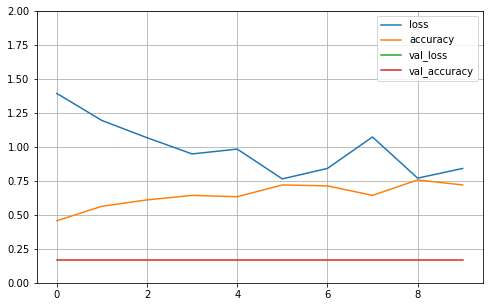

In [36]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
#save_fig("keras_learning_curves_plot")
plt.show()

#### Random Augmentation

In [37]:
x_train_set, y_train_set = np.empty((0,224,224,3), np.uint8), np.empty((0,),np.uint8)
for i in train_set_raw:
  temp = random_crop(i['image'].numpy())
  temp = tf.image.resize(temp, [224,224])
  temp = keras.applications.xception.preprocess_input(temp)
  x_train_set = np.append(x_train_set,np.expand_dims(temp, axis=0), axis=0)
  y_train_set = np.append(y_train_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_test_set, y_test_set = np.empty((0,224,224,3), np.uint8), np.empty((0,),np.uint8)
for i in test_set_raw:
  temp = random_crop(i['image'].numpy())
  temp = tf.image.resize(temp, [224,224])
  temp = keras.applications.xception.preprocess_input(temp)
  x_test_set = np.append(x_test_set,np.expand_dims(temp, axis=0), axis=0)
  y_test_set = np.append(y_test_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

x_valid_set, y_valid_set = np.empty((0,224,224,3), np.uint8), np.empty((0,),np.uint8)
for i in valid_set_raw:
  temp = random_crop(i['image'].numpy())
  temp = tf.image.resize(temp, [224,224])
  temp = keras.applications.xception.preprocess_input(temp)
  x_valid_set = np.append(x_valid_set,np.expand_dims(temp, axis=0), axis=0)
  y_valid_set = np.append(y_valid_set,np.expand_dims(i['label'].numpy(), axis=0), axis=0)

#### Random Augmentation fit

In [40]:
base_model = keras.applications.xception.Xception(weights=None,include_top=False) # 여기를 NONE으로 해야되는지는 고민해보기
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(8, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [41]:
for layer in base_model.layers:
    layer.trainable = False


optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(x_train_set,y_train_set, validation_data=(x_valid_set, y_valid_set),epochs=5)

Epoch 1/5
10/10 [==============================] - 76s 7s/step - loss: 2.0833 - accuracy: 0.1167 - val_loss: 2.0830 - val_accuracy: 0.1500
Epoch 2/5
10/10 [==============================] - 69s 7s/step - loss: 2.0851 - accuracy: 0.1200 - val_loss: 2.0995 - val_accuracy: 0.0900
Epoch 3/5
10/10 [==============================] - 68s 7s/step - loss: 2.0845 - accuracy: 0.1300 - val_loss: 2.0991 - val_accuracy: 0.0800
Epoch 4/5
10/10 [==============================] - 68s 7s/step - loss: 2.0842 - accuracy: 0.1067 - val_loss: 2.0824 - val_accuracy: 0.1700
Epoch 5/5
10/10 [==============================] - 73s 7s/step - loss: 2.0795 - accuracy: 0.1400 - val_loss: 2.0793 - val_accuracy: 0.1700


In [42]:
 for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, validation_data=(x_valid_set, y_valid_set), epochs=10, callbacks=early_stopping)

Epoch 1/10
10/10 [==============================] - 262s 26s/step - loss: 1.4134 - accuracy: 0.4467 - val_loss: 2.0790 - val_accuracy: 0.1700
Epoch 2/10
10/10 [==============================] - 261s 26s/step - loss: 1.2608 - accuracy: 0.5433 - val_loss: 2.0793 - val_accuracy: 0.1700
Epoch 3/10
10/10 [==============================] - 264s 26s/step - loss: 1.0186 - accuracy: 0.6400 - val_loss: 2.0793 - val_accuracy: 0.1700
Epoch 4/10
10/10 [==============================] - 260s 26s/step - loss: 0.9169 - accuracy: 0.6467 - val_loss: 2.0789 - val_accuracy: 0.1700
Epoch 5/10
10/10 [==============================] - 306s 31s/step - loss: 1.2322 - accuracy: 0.5733 - val_loss: 2.0781 - val_accuracy: 0.1700
Epoch 6/10
10/10 [==============================] - 279s 28s/step - loss: 0.9038 - accuracy: 0.6567 - val_loss: 2.0799 - val_accuracy: 0.1700
Epoch 7/10
10/10 [==============================] - 278s 28s/step - loss: 0.8198 - accuracy: 0.7333 - val_loss: 2.0793 - val_accuracy: 0.1700
Epoch 

#### Random Augmentation fit 결과

In [43]:
model.evaluate(x_test_set,y_test_set)

4/4 [==============================] - 15s 3s/step - loss: 2.0783 - accuracy: 0.1500


[2.078272819519043, 0.15000000596046448]

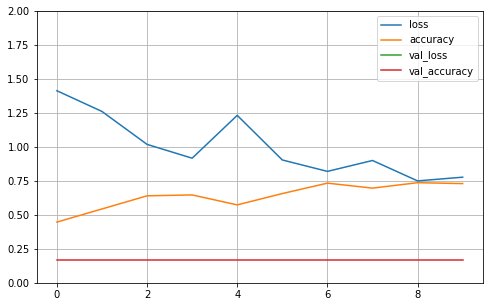

In [44]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
#save_fig("keras_learning_curves_plot")
plt.show()

### Res34 사용

In [45]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [50]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[150, 150, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8, activation="softmax"))

In [61]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[135, 135, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8, activation="softmax"))

#### Central Augment fit

In [51]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, epochs=10, validation_data=(x_valid_set, y_valid_set), callbacks=early_stopping)

Epoch 1/10
10/10 [==============================] - 151s 10s/step - loss: 2.9805 - accuracy: 0.3200 - val_loss: 2735434.0000 - val_accuracy: 0.1500
Epoch 2/10
10/10 [==============================] - 95s 9s/step - loss: 1.8567 - accuracy: 0.3633 - val_loss: 46251068.0000 - val_accuracy: 0.1500
Epoch 3/10
10/10 [==============================] - 94s 9s/step - loss: 1.2743 - accuracy: 0.4933 - val_loss: 5118786.0000 - val_accuracy: 0.1500
Epoch 4/10
10/10 [==============================] - 101s 10s/step - loss: 1.9518 - accuracy: 0.4267 - val_loss: 2981686.5000 - val_accuracy: 0.1500
Epoch 5/10
10/10 [==============================] - 101s 10s/step - loss: 1.2583 - accuracy: 0.5200 - val_loss: 530725.7500 - val_accuracy: 0.1500
Epoch 6/10
10/10 [==============================] - 103s 10s/step - loss: 1.0942 - accuracy: 0.5700 - val_loss: 166078.4062 - val_accuracy: 0.1500
Epoch 7/10
10/10 [==============================] - 103s 10s/step - loss: 1.1242 - accuracy: 0.5733 - val_loss: 73577

#### Central Augment fit 결과

In [52]:
model.evaluate(x_test_set,y_test_set)

4/4 [==============================] - 6s 1s/step - loss: 7255.7715 - accuracy: 0.1100


[7255.771484375, 0.10999999940395355]

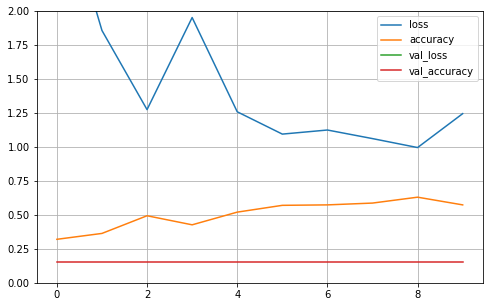

In [56]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
#save_fig("keras_learning_curves_plot")
plt.show()

#### Random Augment fit 

In [62]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(x_train_set, y_train_set, epochs=10, validation_data=(x_valid_set, y_valid_set), callbacks=early_stopping)

Epoch 1/10
10/10 [==============================] - 98s 9s/step - loss: 2.9046 - accuracy: 0.2800 - val_loss: 2076692.3750 - val_accuracy: 0.1500
Epoch 2/10
10/10 [==============================] - 88s 9s/step - loss: 1.6669 - accuracy: 0.3767 - val_loss: 2753169.2500 - val_accuracy: 0.1500
Epoch 3/10
10/10 [==============================] - 87s 9s/step - loss: 1.1618 - accuracy: 0.5467 - val_loss: 770922.1875 - val_accuracy: 0.1600
Epoch 4/10
10/10 [==============================] - 86s 9s/step - loss: 1.2626 - accuracy: 0.4967 - val_loss: 276627.3750 - val_accuracy: 0.1500
Epoch 5/10
10/10 [==============================] - 83s 8s/step - loss: 1.2007 - accuracy: 0.5633 - val_loss: 42559.9141 - val_accuracy: 0.1500
Epoch 6/10
10/10 [==============================] - 85s 9s/step - loss: 1.0658 - accuracy: 0.5967 - val_loss: 4163.2783 - val_accuracy: 0.1500
Epoch 7/10
10/10 [==============================] - 88s 9s/step - loss: 1.1724 - accuracy: 0.5233 - val_loss: 6189.3555 - val_accur

#### Random Augment fit 결과

In [63]:
model.evaluate(x_test_set,y_test_set)

4/4 [==============================] - 6s 1s/step - loss: 1448.0178 - accuracy: 0.1100


[1448.017822265625, 0.10999999940395355]

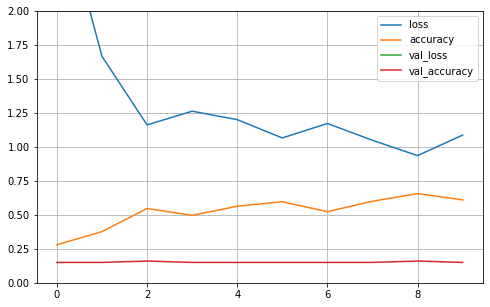

In [64]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,2)
#save_fig("keras_learning_curves_plot")
plt.show()